## Disentangling covariates in real data

## Imports

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Normal
from typing import Optional, Callable, List
from collections import OrderedDict
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
import torch

import json
import time
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from torch.distributions.kl import kl_divergence as kl
from torch.distributions import Normal, Poisson
import torch.nn.functional as F
import DeepDive

In [2]:
import sys
sys.path.insert(0, "../utils")
from utils import preprocess, get_colormap_colors
from downsampled import sample_w_cramer, calc_de

## Setup data and parameters

In [3]:
n_decoders = 20
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
}

train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 512, 
}

In [4]:
adata = sc.read_h5ad("../data/islet.h5ad")

In [5]:
mapper = {0:'alpha',
1:'beta', 
2:'beta', 
3:'beta', 
4:'alpha', 
5:'beta', 
6:'delta', 
7:'acinar', 
8:'alpha', 
9:'ductal', 
10:'gamma', 
11:'stellate', 
12:'immune', 
13:'endothelial',
}
adata.obs['celltype'] = adata.obs.leiden.map(mapper)

In [6]:
discrete_covriate_keys = ['donor', 'celltype', 'Disease', 'Gender']
continuous_covriate_keys = ['Age', 'HbA1c', 'Purity', 'map_frac', 'BMI']

In [7]:
adata = adata[adata.obs.celltype == 'beta']

In [8]:
adata = preprocess(adata, discrete_covriate_keys, continuous_covriate_keys, frac = 0.1).copy()

In [9]:
data = adata.copy()

## Make baseline with balanced covariates

In [10]:
data_sampled = sample_w_cramer(data, 40000, 0)

In [11]:
data_sampled.write_h5ad('../data/Downsampled_real/baseline.h5ad')

In [12]:
df_full_sex, df_full_d = calc_de(data_sampled)
df_full_sex = df_full_sex.set_index('M_n')
df_full_d = df_full_d.set_index('T2D_n')

In [13]:
discrete_covriate_keys = ['Gender', 'Disease']


## Loop through downsampled datasets with variable entanglement

In [14]:
runs = []
entanglement = []
indexes = []
cramers = []
average_precision_lfc = []
average_precision_dd = []

files = glob.glob('output*', root_dir = '../data/Downsampled_real')
for f in files:
    _, run, idx, i, cramer = f.split('.tsv')[0].split('_')
    try:
        i = float(i)
        idx = int(idx)
    except:
        pass
    run = int(run)
    runs.append(run)
    indexes.append(idx)
    entanglement.append(i)
    cramers.append(cramer)
    
    df_entangled_d = pd.read_csv('../data/Downsampled_real/' + f, sep = '\t', index_col = 0)
    
    df_entangled_d['M_l_full'] = df_full_sex['M_l'][df_entangled_d.index]
    df_entangled_d['M_p_full'] = df_full_sex['M_p'][df_entangled_d.index]
    df_entangled_d['T2D_l_full'] = df_full_d['T2D_l'][df_entangled_d.index]
    df_entangled_d['T2D_p_full'] = df_full_d['T2D_p'][df_entangled_d.index]

    average_precision_lfc.append(average_precision_score(df_entangled_d.M_p_full < 0.05, abs(df_entangled_d.M_l)))
    average_precision_dd.append(average_precision_score(df_entangled_d.M_p_full < 0.05, abs(df_entangled_d.model_M)))
    

In [15]:
result = pd.concat([pd.Series(x) for x in [indexes, entanglement, runs, 
                                           average_precision_lfc, average_precision_dd]],axis = 1)
result.columns = ['idx', 'i', 'run', 'lfc', 'dd']
result = result.sort_values('idx')

In [16]:
mean = result.groupby('i').mean()
sd = result.groupby('i').std()

In [17]:
colors = get_colormap_colors('RdBu', 11)

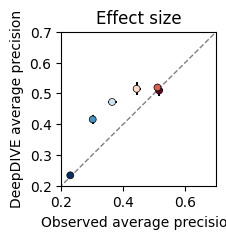

In [18]:
#On fold change

fig, ax = plt.subplots(1,1, figsize = (2,2))

X_plot = np.linspace(0.0, 1)
Y_plot = X_plot
sns.lineplot(x=X_plot, y=Y_plot, color = 'k', linestyle='--', linewidth=1, ax = ax, alpha = 0.5)
    
sns.scatterplot(mean, x = 'lfc', y = 'dd', c = [colors[int(i*10)] for i in mean.index], s = 25, ax = ax, linewidth = 0.5, edgecolor = 'k')

plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
ax.errorbar(mean.lfc, mean.dd, xerr=sd.lfc, yerr=sd.dd, fmt="none", color="k")

plt.xlim(0.2, 0.7)
plt.ylim(0.2, 0.7)
plt.xlabel('Observed average precision')
plt.ylabel('DeepDIVE average precision')
plt.title('Effect size')
plt.savefig('../figures/S4G.pdf')
